# Analyse des clients du site d'e-commerce Olist

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
import random
#from function_utils import haversine_vectorize

In [7]:
sns.set_palette("Pastel2")

On débute l'analyse de notre base de clients par la création d'une segmentation RFM (Recency, Frequency, MonetaryValue). <br>
Ce type de segmentation est utilisé en marketing pour pouvoir découper les clients en segments actionnables et ainsi adapter les stratégies en fonction du type de client. <br>
La segmentation RFM se base sur des habitudes de consommations comme la date du dernier achat (Recency), la fréquence d'achat (Frequency) et la valeur moyenne/la somme moyenne dépensée lors d'une commande (MonetaryValue).

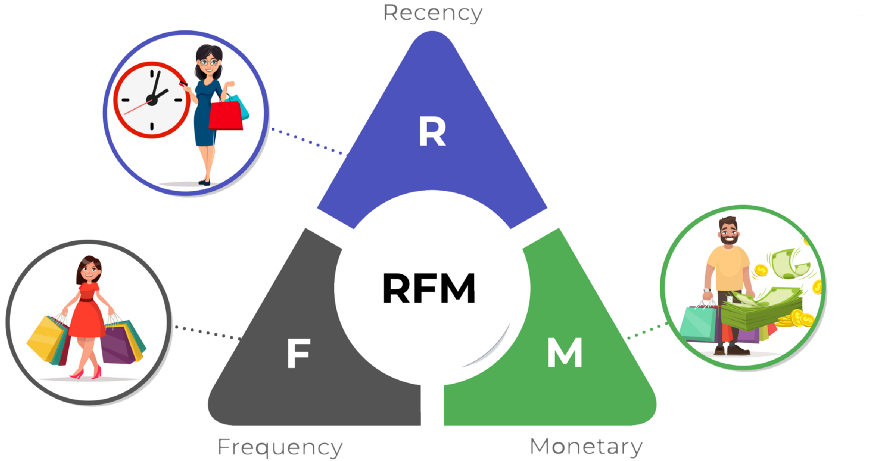

### Information clients

On va commencer par extraire les informations clients pour pouvoir déterminer les premières variables de notre segmentation.

In [30]:
df_customers = pd.read_csv('C:/Users/lenovo/Olist/olist_customers_dataset.csv')
df_geo = pd.read_csv('C:/Users/lenovo/Olist/olist_geolocation_dataset.csv')

In [31]:
# Add geolocation information
df_customers = pd.merge(df_geo, df_customers,
                        right_on=["customer_zip_code_prefix",
                                  "customer_city", "customer_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city", "geolocation_state"],
                        how="right")
df_customers.drop(["geolocation_zip_code_prefix", "geolocation_city",
                   "geolocation_state"], axis=1, inplace=True)
df_customers = df_customers[["customer_id", "customer_unique_id",
                             "customer_city", "geolocation_lat",
                             "geolocation_lng"]]
df_customers.columns = ["customer_id", "customer_unique_id",
                        "customer_city", "customer_latitude",
                        "customer_longitude"]
df_customers.head()

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.509897,-47.397866
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.497396,-47.399241
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.510459,-47.399553
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.480940,-47.394161
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.515413,-47.398194


In [32]:
df_customers.shape

(14129681, 5)

In [33]:
df_customers.drop_duplicates(subset="customer_unique_id", inplace=True)

In [34]:
df_customers.shape

(96096, 5)

In [35]:
print("Nombre d'id unique:", df_customers["customer_unique_id"].nunique())

Nombre d'id unique: 96096


In [36]:
print("Nombre d'id clients:", df_customers["customer_id"].nunique())

Nombre d'id clients: 96096


### Information sur les commandes

On va ensuite s'intéresser aux informations des commandes pour des calcules numériques.

In [37]:
df_orders = pd.read_csv('C:/Users/lenovo/Olist/olist_orders_dataset.csv')

In [38]:
#Association entre clients et commandes 
#Afin de calculer la fréquence et la récence  
df = pd.merge(df_customers,df_orders,left_on="customer_id",
              right_on="customer_id",
              how="right")
df.drop_duplicates(subset="customer_id",
                   inplace=True)

In [39]:
df_orders_payments =  pd.read_csv('C:/Users/lenovo/Olist/olist_order_payments_dataset.csv')

In [40]:
#Association entre les clients, les commandes et les paiements des commandes 
#Afin de calculer la valeur monétaire
df = pd.merge(df, df_orders_payments, left_on="order_id",
              right_on="order_id", how="right")

In [41]:
sum(df.duplicated())

0

In [42]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_city',
       'customer_latitude', 'customer_longitude', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [43]:
# Transformation timestamps into datetime
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols],
                              format="%Y-%m-%d", errors="ignore")

In [44]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_city',
       'customer_latitude', 'customer_longitude', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [45]:
df.head()

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,0a8556ac6be836b46b3e89920d59291c,708ab75d2a007f0564aedd11139c7708,teofilo otoni,-17.851690,-41.493610,b81ef226f3fe1789b1e8b2acac839d17,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,1,credit_card,8,99.33
1,f2c7fc58a9de810828715166c672f10a,a8b9d3a27068454b1c98cc67d4e31e6f,sao paulo,-23.470015,-46.634846,a9810da82917af2d9aefd1278f1dcfa0,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,1,credit_card,1,24.39
2,25b14b69de0b6e184ae6fe2755e478f9,6f70c0b2f7552832ba46eb57b1c5651e,sao paulo,-23.454897,-46.656832,25e8ea4e93396b6fa0d3dd708e76c1bd,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,1,credit_card,1,65.71
3,7a5d8efaaa1081f800628c30d2b0728f,87695ed086ebd36f20404c82d20fca87,juiz de fora,-21.750376,-43.342449,ba78997921bbcdc1373bb41e913ab953,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04,1,credit_card,8,107.78
4,15fd6fb8f8312dbb4674e4518d6fa3b3,4291db0da71914754618cd789aebcd56,conchas,-23.015379,-48.008990,42fdf880ba16b47b59251dd489d4441a,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13,1,credit_card,2,128.45


In [46]:
df.to_csv("C:/Users/lenovo/Olist/df.csv")

## 1.1) Feature Engineering

Récence : La différence entre aujourd'hui et la date du dernier achat du client. (en jours) <br>
Fréquence : Nombre total d'achats. <br>
Monétaire : Dépenses totales du client.   

In [47]:
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)

In [48]:
# Recency: the difference between today and the customer's last purchase date, in days
# Frequency: total number of purchases.
# Monetary: total spend by the customer.
rfm_custom = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})
rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]
data = rfm_custom.copy().reset_index()

In [50]:
rfm_custom[rfm_custom['MonetaryValue'] <0]

,Recency,Frequency,MonetaryValue
customer_unique_id,,,


In [51]:
data.to_csv("C:/Users/lenovo/Olist/data_rfm.csv")

## 1.2) Création des segments

Etant donnée que les 75% de clients ont passé seulement une commande, nous alons faire uniquement 2 classes :
<li> Les clients qui ont achetés seulement un produit </li> 
<li> Les clients qui ont achetés plus d'un produit </li> 

In [52]:
# Calcul des scores à l'aide des quartiles
# Sauf pour la fréquence
# Etant donnée que les 75% de clients ont passé seulement une commande, 
# nous alons faire uniquement 2 classes :
#Les clients qui ont achetés seulement un produit
#Les clients qui ont achetés plus d un produit

data['r_quartile'] = pd.qcut(data['Recency'], 4, ['1', '2', '3', '4'])
data['f_bins'] = pd.cut(data['Frequency'], 2, labels=['2', '1'])
data['m_quartile'] = pd.qcut(data['MonetaryValue'], 4, ['4', '3', '2', '1'])

In [53]:
# Creation of RFM Score with the concatenation of
# R, F & M quartile/bins
data['RFM_Score'] = data["r_quartile"].astype(str) \
                    + data["f_bins"].astype(str) \
                    + data["m_quartile"].astype(str)
data.sort_values("RFM_Score", ascending=True)

,customer_unique_id,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score
78444,d0c3e4c736d2c8a157a86f567a87d0e7,117,1,187.980,1,2,1,121
70724,bc2eb3caac79e71259bac8f30248dcca,72,1,298.180,1,2,1,121
16958,2d0b5c3a0b200f10d09a3927412a9203,79,1,441.500,1,2,1,121
35315,5da812ba78edf4151612ede627e1192c,164,1,189.010,1,2,1,121
94183,fae2f0c0e291974ed37697cf9880fe99,126,1,205.500,1,2,1,121
...,...,...,...,...,...,...,...,...
88064,ea609ced31eaa6eae3922c127c19d266,456,2,35.305,4,2,4,424
91541,f3cb4bf78563e8f29fb8df63f3ae2748,473,1,51.140,4,2,4,424
84295,e048d4f04bde3e12f337cf38d680345d,612,1,38.040,4,2,4,424
25928,44df09ec29e6f3cd6820e574f32fc151,541,1,30.860,4,2,4,424


***
**Bilan**
***
On remarque que la fréquence d'achat est le plus souvent de 1. Le choix a donc été fait de faire une binarisation de cette donnée en 1 (un achat) et 2 (plus d'un achat). Ce problème sur la fréquence d'achat va se répercuter sur la récence. Enfin, pour le montant dépensé, les calculs ont pu être fait classiquement. La séparation a été réalisée sur la base des quartiles. 

Une fois la discrétisation des variables R, F et M réalisée, on crée un score qui correspond à la concaténation de ces trois indices. Ainsi, on obtient une segmentation RFM composée de 32 segments (4 x 2 x 4).

## 1.3) Analyse de la segmentation RFM

### Giving a name of RFM scores

Avec le score RFM, nous pouvons séparer les clients en 4 4 2 = 32 classes. Nous allons créer 9 classes actionnables :

<li> Meilleur: R = 1, F = 1 et M = 1 </li>

<li> Nouveau: R = 1 et F = 2 </li>

<li> Actif - valeur élevée: R = 1 et M = 1 ou 2 </li>

<li> Warm: R = 2 </li>

<li> A reconquérir: R = 3 ou 4 ET (F = 1 ou M = 1) </li>

<li> Cold: R = 3 </li>

<li> Presque perdu: R = 4</li>

In [54]:
data['RFM_Score'].value_counts()

122    6188
424    6170
323    6163
121    6162
423    6119
222    6057
322    6041
321    6022
224    6011
221    5980
124    5941
324    5899
223    5874
123    5865
421    5852
422    5745
414       4
314       2
Name: RFM_Score, dtype: int64

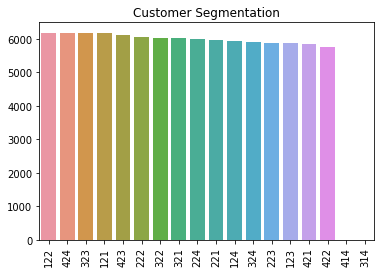

In [55]:
# Visualization of RFM Segments
sgm= data["RFM_Score"].value_counts()
plt.figure()
sns.barplot(x=sgm.index,y=sgm.values)
plt.xticks(rotation=90)
plt.title('Customer Segmentation')
plt.show()

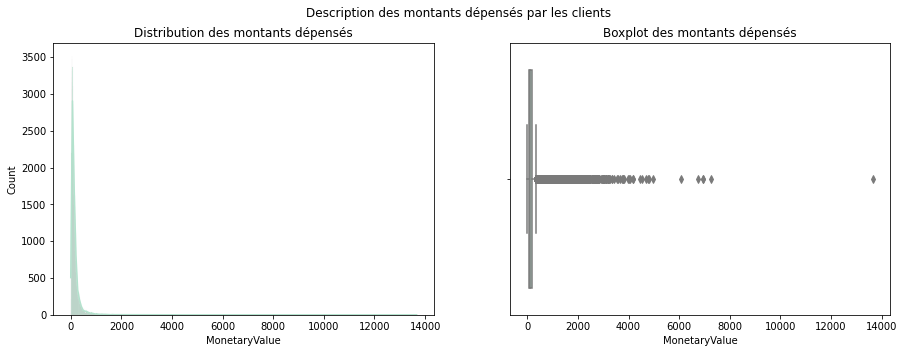

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0], x="MonetaryValue", data=data, kde=True)
axes[0].set_title("Distribution des montants dépensés")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=data)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

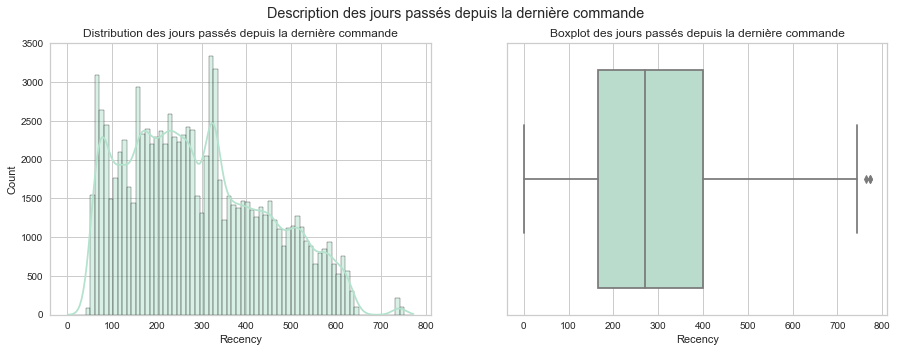

In [1092]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des jours passés depuis la dernière commande')

sns.histplot(ax=axes[0], x="Recency", data=data, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="Recency", data=data)
axes[1].set_title("Boxplot des jours passés depuis la dernière commande")

plt.show()

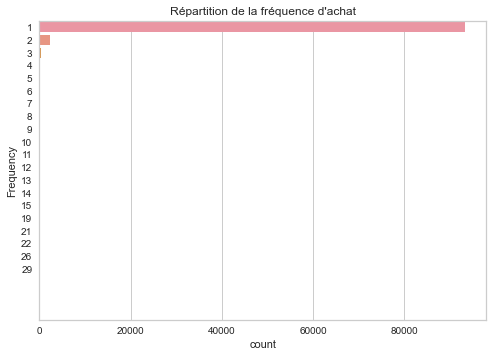

In [1093]:
sns.countplot(y="Frequency", data=data)
plt.ylim(23)
plt.title("Répartition de la fréquence d'achat")

plt.show()

## 1.4) Conclusion

La fréquence et la récence ne semblent pas être très discriminants. En effet, la plupart des clients réalise un seul achat. De même, il est difficile de savoir s'ils reviennent régulièrement acheter donc la récence est très variable. Les sommes dépensées atteignent un maximum de 14.000 Réaux. 

En inspectant le fonctionnement du site, il s'avère que l'on peut commander sans avoir besoin de créer un compte. On ne peut donc pas savoir si une personne commande plusieurs fois et obtenir les informations nécessaires. Il pourrait être intéressant d'instaurer un système de compte pour obtenir des informations plus stables sur la récence et la fréquence. 

In [57]:
del df_orders_payments
del rfm_custom

In [58]:
gc.collect()

73

In [59]:
data.set_index("customer_unique_id", inplace=True)

In [60]:
data.head()

,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,1,2,2,122
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,1,2,4,124
0000f46a3911fa3c0805444483337064,586,1,86.22,4,2,3,423
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,3,2,4,324
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,3,2,1,321


In [61]:
data.shape

(96095, 7)

In [62]:
data.to_csv("C:/Users/lenovo/Olist/data_segmentation_rfm.csv")

# 2) Segmentation de la RFM par des méthodes non supervisées

In [64]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import DBSCAN
from sklearn import metrics
import gc
from sklearn.model_selection import GridSearchCV
import time
import missingno as msno

In [65]:
df = pd.read_csv("C:/Users/lenovo/Olist/data_rfm.csv")
df.set_index("customer_unique_id", inplace=True)
df.head(3)

,Unnamed: 0,Recency,Frequency,MonetaryValue
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,161,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,164,1,27.19
0000f46a3911fa3c0805444483337064,2,586,1,86.22


In [66]:
df.drop(['Unnamed: 0'], axis = 1,inplace=True)

In [67]:
df.head()

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
0004aac84e0df4da2b147fca70cf8255,337,1,196.89


In [68]:
df.shape

(96095, 3)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96095 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        96095 non-null  int64  
 1   Frequency      96095 non-null  int64  
 2   MonetaryValue  96095 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.9+ MB


## 2.1) Préparation des données

In [70]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(df['Recency'])
customers["Frequency"] = df["Frequency"]
customers["MonetaryValue"] = np.log1p(df["MonetaryValue"])
customers.reset_index(inplace=True)

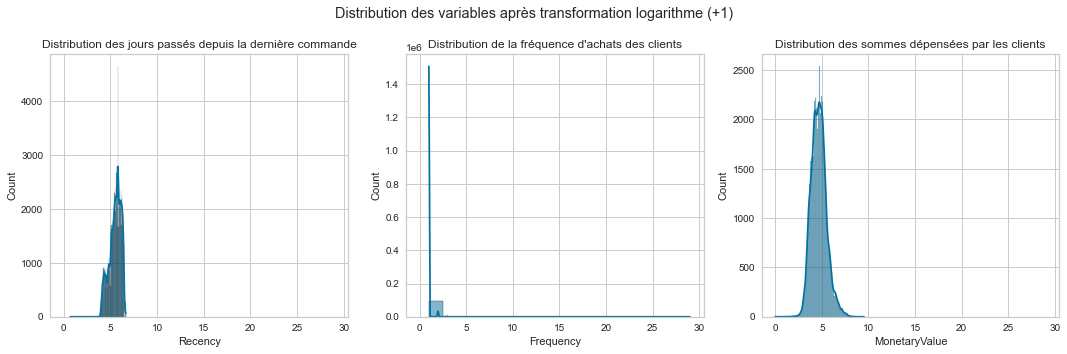

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation logarithme (+1)')

sns.histplot(ax=axes[0], x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1], x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2], x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show()

In [10]:
customers

,customer_unique_id,Recency,Frequency,MonetaryValue
0,0000366f3b9a7992bf8c76cfdf3221e2,5.087596,1,4.962145
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5.105945,1,3.338967
2,0000f46a3911fa3c0805444483337064,6.375025,1,4.468434
3,0000f6ccb0745a6a4b88665a16c9f078,5.916202,1,3.798182
4,0004aac84e0df4da2b147fca70cf8255,5.823046,1,5.287711
...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,6.208590,1,7.634540
96091,fffea47cd6d3cc0a88bd621562a9d061,5.743003,1,4.449452
96092,ffff371b4d645b6ecea244b27531430a,6.428105,1,4.731450
96093,ffff5962728ec6157033ef9805bacc48,5.135798,1,4.902976


In [72]:
customers.set_index("customer_unique_id", inplace=True)

In [73]:
customers

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,5.087596,1,4.962145
0000b849f77a49e4a4ce2b2a4ca5be3f,5.105945,1,3.338967
0000f46a3911fa3c0805444483337064,6.375025,1,4.468434
0000f6ccb0745a6a4b88665a16c9f078,5.916202,1,3.798182
0004aac84e0df4da2b147fca70cf8255,5.823046,1,5.287711
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,6.208590,1,7.634540
fffea47cd6d3cc0a88bd621562a9d061,5.743003,1,4.449452
ffff371b4d645b6ecea244b27531430a,6.428105,1,4.731450


In [74]:
scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [0. 0. 0.]
Standard Deviation: [1. 1. 1.]


***
**Note :**
***
La transformation logarithmique a permis de modifier la forme de la distribution des variables Recency et MonetaryValue pour qu'elle soit proche d'une distribution normale. Cette modification permet de rendre les modèles d'apprentissage non-supervisé comme l'algorithme K-Means d'être plus performant.

Une seconde étape a été de standardiser nos données. Ainsi, nos données ont toutes une moyenne de 0 avec un écart-type de 1.
Là, encore cette modification a pour but de mettre en échelle nos variables et améliorer la performance de nos modèles d'apprentissage non-supervisé. 

## 2.2) Visualization des données 

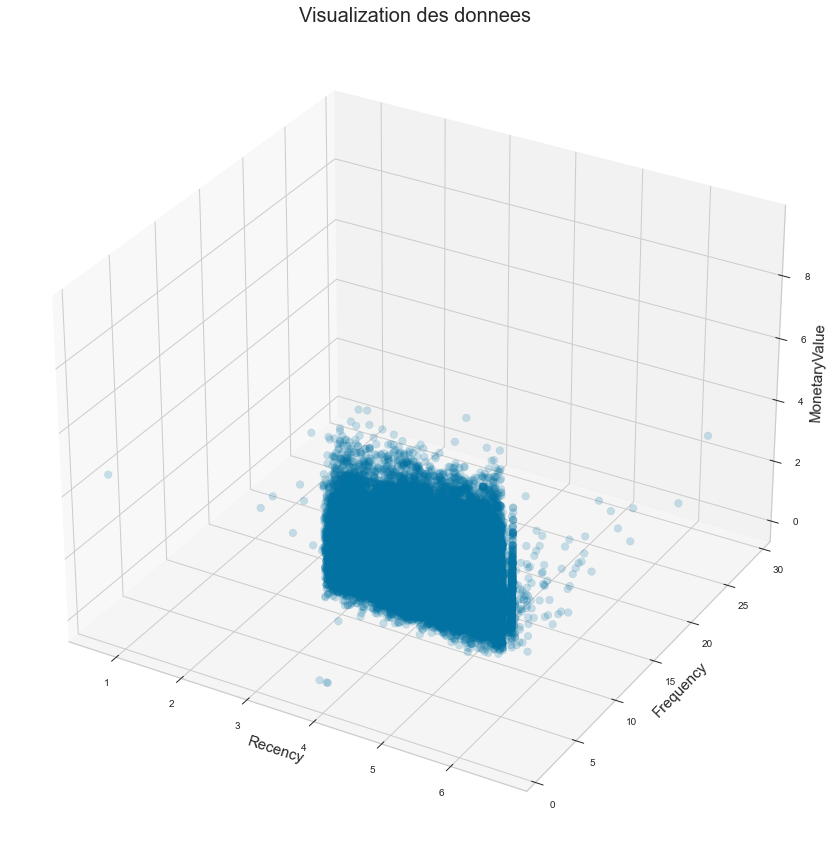

In [75]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('Recency', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_zlabel('MonetaryValue', fontsize=15)
ax.set_title('Visualization des donnees', fontsize=20)

ax.scatter(customers['Recency'], customers['Frequency'],
           customers['MonetaryValue'], s=60, alpha=0.2)
ax.grid()

## 2.3) Réduction de dimensions

La réduction de dimension a pour but de faciliter la visualisation de nos données en les ramenant dans un espace en 2 dimensions (même si dans ce cas, il aurait possible de les visualiser en 3 dimensions). De plus, la réduction de dimensions permet de diminuer le temps de calcul des algorithmes de clustering. 

In [76]:
n_comp = 2
pca = PCA(n_components=n_comp)
features_col = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

In [77]:
features = customers.values

In [78]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features_col))

NameError: name 'display_circles' is not defined

In [79]:
customers.shape

(96095, 3)

In [80]:
from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
data_iso = isomap.fit_transform(customers.sample(9000))

In [22]:
isomapDf = pd.DataFrame(data=data_iso, columns=['principal component 1', 'principal component 2'])

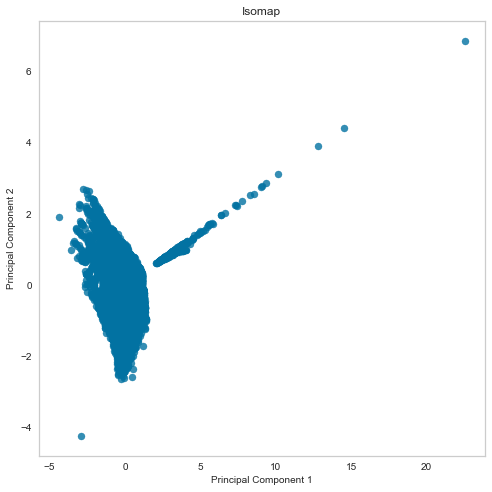

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('Isomap', fontsize=12)

ax.scatter(isomapDf['principal component 1'],
           isomapDf['principal component 2'], s=50, alpha=0.8)
ax.grid()

## 2.4) Clustering : 

Nous allons créer un clustering hiérarchique sur le jeu  de données d'un échantillon de 9000.

### 2.4.1) Visualisation des données

In [22]:
from random import sample

In [23]:
customers.shape

(96095, 3)

In [25]:
customers_echantillon  = customers.sample(9000)

Text(0, 0.5, 'MonetaryValue')

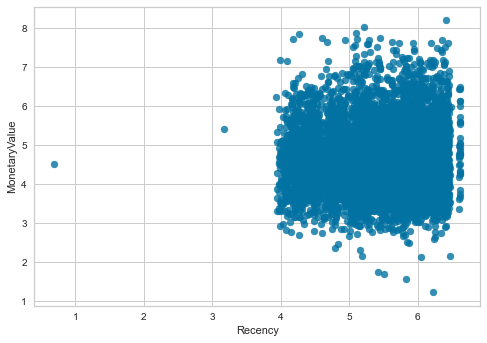

In [26]:
colors = np.random.rand(50)
plt.scatter(customers_echantillon['Recency'],customers_echantillon['MonetaryValue'],alpha=0.8)
plt.xlabel('Recency')
plt.ylabel('MonetaryValue')

Mais avant d'appliquer le clustering hiérarchique, nous devons normaliser les données afin que l'échelle de chaque variable soit la même. Pourquoi est-ce important? Eh bien, si l'échelle des variables n'est pas la même, le modèle peut devenir biaisé vers les variables avec une magnitude plus élevée comme Recence ou Montant.

Donc, commençons par normaliser les données et amenons toutes les variables à la même échelle :

In [27]:
from sklearn.preprocessing import normalize
data_scaled = normalize(customers_echantillon)
data_scaled = pd.DataFrame(data_scaled, columns=customers_echantillon.columns)
data_scaled.head()

,Recency,Frequency,MonetaryValue
0,0.786780,0.135046,0.602279
1,0.752158,0.136423,0.644707
2,0.744040,0.166605,0.647029
3,0.789495,0.125783,0.600730
4,0.797613,0.151560,0.583818


Ici, nous pouvons voir que l'échelle de toutes les variables est presque similaire.Dessinons d'abord le dendrogramme pour nous aider à décider du nombre de clusters pour ce problème particulier :

### 2.4.2 Dendogram

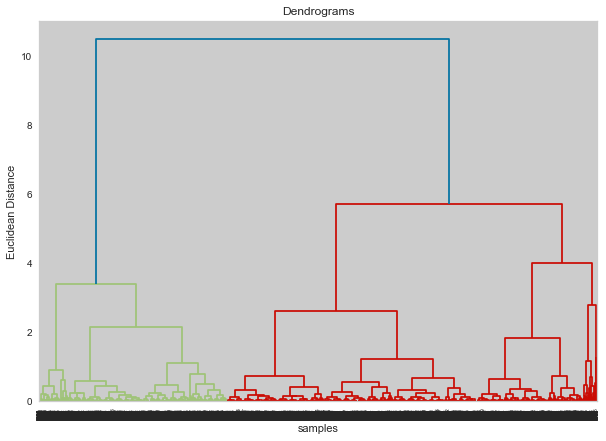

In [28]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
plt.xlabel('samples')
plt.ylabel('Euclidean Distance')
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))


L'axe des x contient les échantillons et l'axe des y représente la distance entre ces échantillons. La ligne verticale avec une distance maximale est la ligne bleue et nous pouvons donc décider d'un seuil de 7 et couper le dendrogramme :

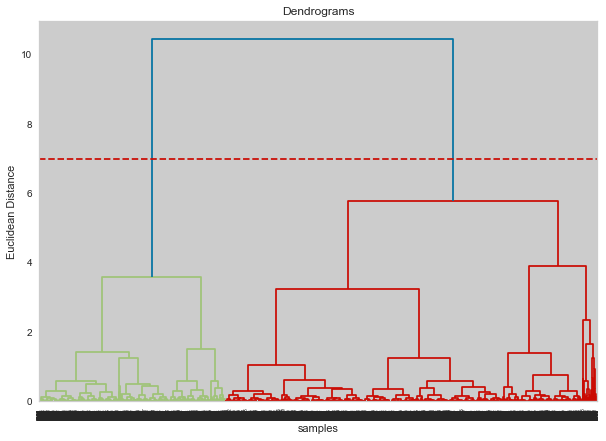

In [151]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms") 
plt.xlabel('samples')
plt.ylabel('Euclidean Distance')
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=7, color='r', linestyle='--')

In [64]:
#fusions = linkage(customers_echantillon, method='ward', metric='euclidean')

In [63]:
#fig = plt.figure(figsize=(10, 10))

# set params of the graphic
###ax = fig.add_subplot(111)
##ax.set_xlabel('Clients', fontsize=12)
#x.set_ylabel('Distance Euclidienne', fontsize=12)
#ax.set_title('Dendrogram', fontsize=13)
#ax.tick_params(axis='both', which='major', labelsize=13)


#dendrogram(fusions,
           #leaf_rotation=90,
           #leaf_font_size=12,
           #truncate_mode='lastp', 
           #show_leaf_counts=True
           #)

#plt.show()

### 2.4.3 clustering hierarchique 

In [29]:
import time
time_start = time.time()
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)
print(time.time()-time_start)

1.9918200969696045


In [31]:
time.time()

1648901060.520715

In [32]:
silhouette_score(data_scaled, cluster.labels_)

0.4973128703060523

In [29]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
hc.fit_predict(data_scaled)

array([1, 2, 2, ..., 0, 1, 0], dtype=int64)

In [30]:
silhouette_score(data_scaled, hc.labels_)

0.3586219601424629

Text(0, 0.5, 'MonetaryValue')

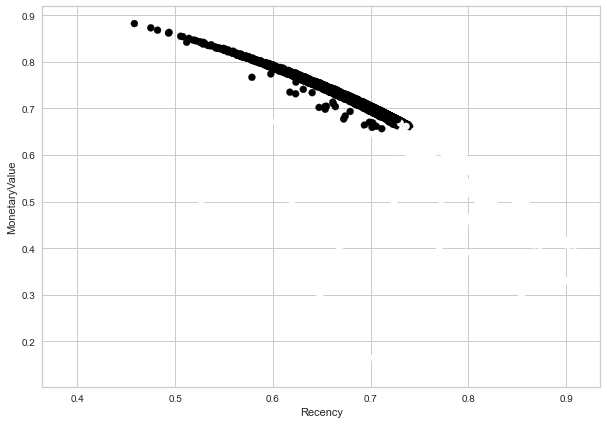

In [31]:
plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['Recency'], data_scaled['MonetaryValue'], c=cluster.labels_) 
plt.xlabel('Recency')
plt.ylabel('MonetaryValue')

<strong> Nous ne pouvons pas clairement visualiser les deux clusters . </strong>

### 2.4.4 K-Means

On va utiliser un algorithme K-Means qui se base sur des calculs de distance entre les points de notre jeu de données et le centroïde.

Nous allons tout d'abord performer l'algorithme k-means sur notre notre jeu de donnés afin de rechercher le nombre de clusters optimal :

### 2.4.4.1 Recherce de nombre de clusters optimal à l'aide de coefficient de silhouette

On va chercher à déterminer le nombre de clusters (le K du K-Means) optimal.

In [32]:
silhouette = []

In [33]:
k = list(range(2,9))

In [35]:
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=3)
    y_pred = kmeans.fit_predict(customers)
    score = silhouette_score(customers, kmeans.labels_)
    silhouette.append(score)

In [36]:
silhouette

[0.33865411604189954,
 0.35190208232069803,
 0.3355221826109628,
 0.34191604952744514,
 0.3361227892863868,
 0.3142900985171993,
 0.3215198228943416]

In [37]:
y_pred

array([1, 7, 3, ..., 3, 1, 3])

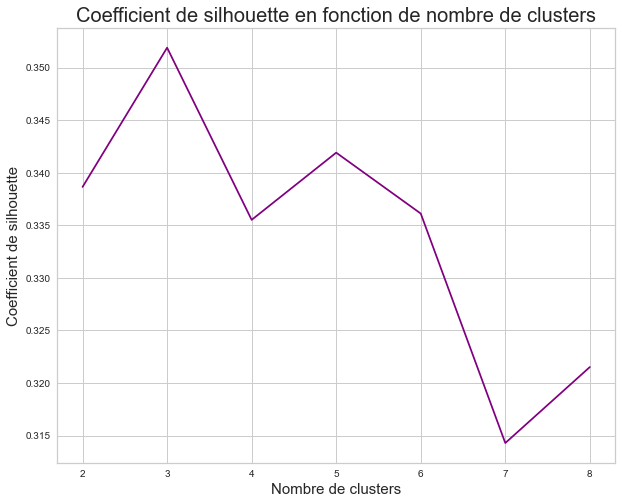

In [38]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Nombre de clusters', fontsize=15)
ax.set_ylabel('Coefficient de silhouette', fontsize=15)
ax.set_title(
    'Coefficient de silhouette en fonction de nombre de clusters', fontsize=20)

plt.plot(k, silhouette, color="purple")

Le coefficient de silhouette maximal est atteint avec une segmentation en trois clusters qui correspond à celle trouvé dans la classification hiérarchique.

Selon la méthode du coude, le nombre de cluster idéal est de **3**. On va donc entraîner notre modèle avec ce paramètre.

In [39]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

### Entrainement de l'algorithme

In [33]:
# Fitting KMeans
time_start = time.time()
km = KMeans(n_clusters=3, random_state=42)

# Prediction
#label = km.fit_predict(data_pca)
label = km.fit_predict(customers)
centroids = km.cluster_centers_
u_labels = np.unique(label)
print(time.time()-time_start)


1.740121603012085


In [155]:
centroids

array([[5.53239439, 0.7490146 , 4.2141887 , 2.34731385, 6.09383891],
       [5.40639456, 0.72478926, 4.42250983, 1.66406218, 3.56398319],
       [5.52777157, 0.70626935, 5.33588709, 2.69671692, 6.74112103]])

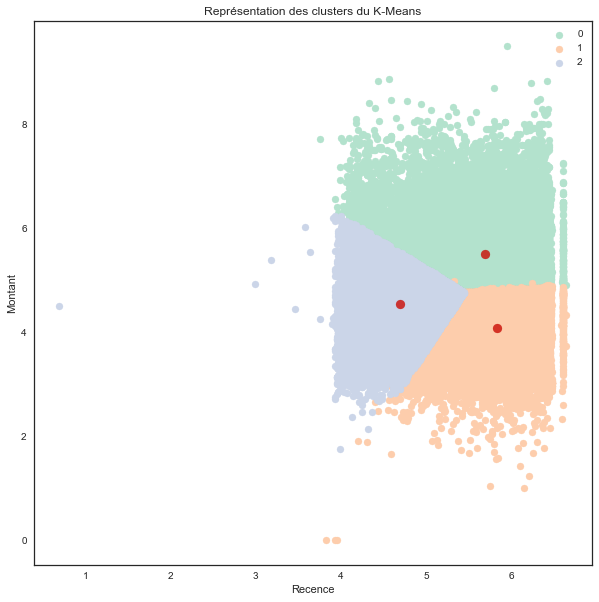

In [41]:
# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(features[label==i, 0], features[label==i, 2], label = i)
plt.scatter(centroids[:, 0], centroids[:,2], s=80, alpha=0.8, color='r')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.xlabel('Recence')
plt.ylabel('Montant')
plt.show()

## 2.4.2.1) Description des clusters obtenus avec le modèle

In [42]:
import pandas as pd
y_pred = pd.DataFrame(label, index=customers.index)

In [43]:
y_pred.rename({0: 'Cluster'}, axis=1, inplace=True)

Pour avoir une idée sur l'effectif de chaque cluster:

In [1159]:
effectif_clusters_k_means = pd.DataFrame(y_pred['Cluster'].value_counts())
effectif_clusters_k_means

,Cluster
1,40341
0,32140
2,23614


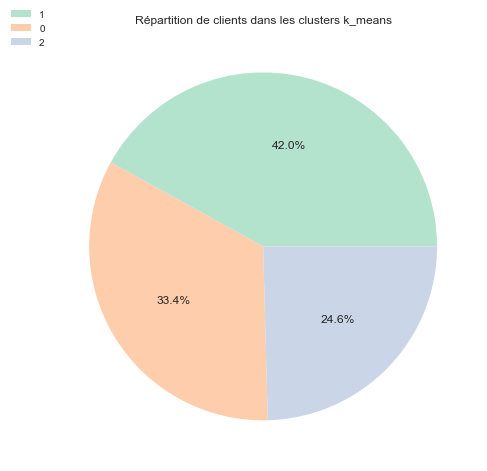

In [1160]:
fig = plt.figure(figsize=(8, 8))

plt.title('Répartition de clients dans les clusters k_means')
plt.pie(effectif_clusters_k_means['Cluster'], autopct='%1.1f%%')
plt.legend(effectif_clusters_k_means.index,
           loc='center left', bbox_to_anchor=(-0.1, 1.))

In [1161]:
customers["Cluster"] = km.labels_
customers.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,5.69,1.01,5.52
1,5.83,1.08,4.10
2,4.70,1.02,4.55


In [1162]:
df_normalized = pd.DataFrame(customers,
                             columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue"],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,2,Recency,5.087596
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,Recency,5.105945
2,0000f46a3911fa3c0805444483337064,1,Recency,6.375025
3,0000f6ccb0745a6a4b88665a16c9f078,1,Recency,5.916202
4,0004aac84e0df4da2b147fca70cf8255,0,Recency,5.823046


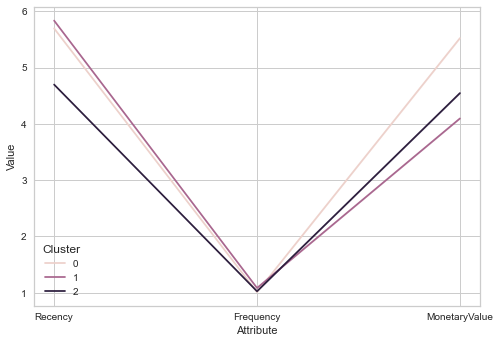

In [1163]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

### Evaluation du modèle

In [1164]:
print("Silhouette Score:", silhouette_score(customers, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(customers, label))

Silhouette Score: 0.5231101689414738
Score de Davies-Bouldin: 0.7485864275142284


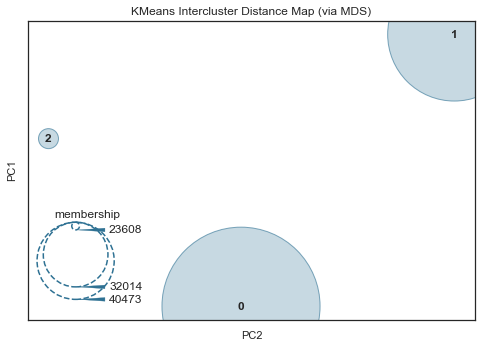

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=3, random_state=42))

In [180]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(3, random_state=42), customers)

## 2.2) Conclusion

 Deux clusters semblent équilibrés et le dernier est plutôt faible. Ce cluster le plus petit est celui qui contient les clients ayant une fréquence d'achat supérieur à 2. Il s'agit donc des clients qui ont crée un compte et qui sont susceptibles de revenir régulièrement. Le reste des indices montre un clustering de bonne qualité. Cependant, la lecture des données ne permet de distinguer de véritables segmentations actionnables (outre les clients fidèles). On va donc essayer d'affiner cette segmentation en y ajoutant des variables supplémentaires. 

## DBSCAN

L'avantage de DBSCAN est que nous ne sommes pas obligées de définir à l'avance le nombre de clusters. 

Nous allons essayer de rechercehr les meilleurs paramètres avec une recherche sur grille en imposant le nombre de clusters entre 2 et 6, ce qui est beaucoup plus pratique pour interprétation de la segmentation.

In [35]:
customers_echantillon  = customers.sample(9000)

In [36]:
X = StandardScaler().fit_transform(customers_echantillon)

In [37]:
list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [38]:
DBSCAN_Silhouette = []

In [132]:
for i in list:
    Model = DBSCAN(eps=i, min_samples=3)
    y_pred_DB = Model.fit_predict(X)
    score_DB = silhouette_score(X, Model.labels_)
    DBSCAN_Silhouette.append(score_DB)

In [133]:
DBSCAN_Silhouette

[-0.3181844920486827,
 -0.14222018265647013,
 0.3601592803369337,
 0.40498276406962014,
 0.49630357853361984,
 0.49734445914547876,
 0.4995201996657946,
 0.4996425339540468,
 0.49966823058042875,
 0.4996884589457551]

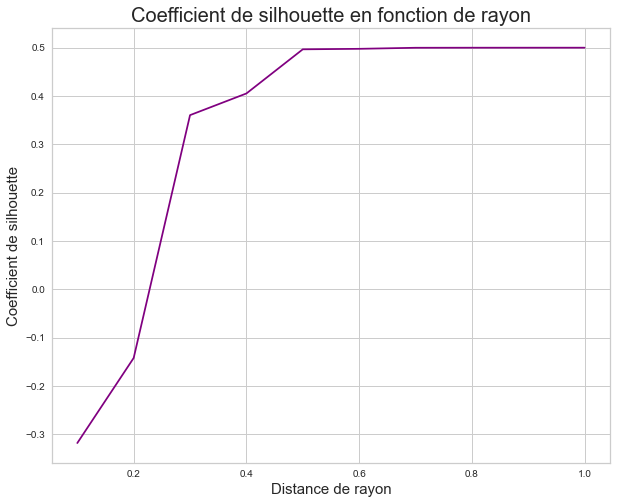

In [134]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Distance de rayon', fontsize=15)
ax.set_ylabel('Coefficient de silhouette', fontsize=15)
ax.set_title(
    'Coefficient de silhouette en fonction de rayon', fontsize=20)

plt.plot(list, DBSCAN_Silhouette, color="purple")

le coefficient de silhouette maximal est atteint avec une distance d'eps = 1

0.40331387519836426
Number of clusters: 7
Silhouette Coefficient: 0.451


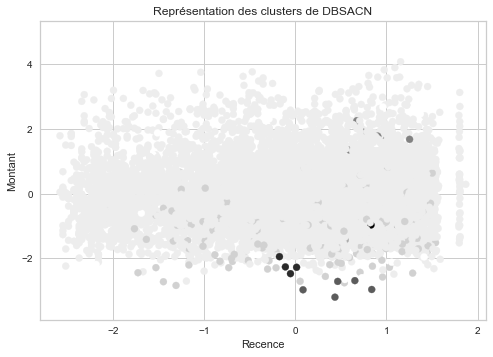

In [40]:
time_start = time.time()
prediction = DBSCAN(eps=0.5, min_samples=3).fit_predict(X)
print(time.time()-time_start)
print('Number of clusters: {}'.format(len(set(prediction[np.where(prediction != -1)]))))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, prediction))

plt.scatter(X[:,0], X[:,2], c=prediction)
plt.title('Représentation des clusters de DBSACN')
plt.xlabel('Recence')
plt.ylabel('Montant')
plt.show()


In [50]:
del data_pca
del df
del customers
del df_normalized
del df_nor_melt

In [51]:
gc.collect()

17489

# 3) Segmentation sur 5 variables explicatives

On va créer de nouvelles variables que l'on va ajouter pour pouvoir obtenir une segmentation plus fine. Parmi ces variables, on va ajouter le nombre de jours entre la commande (order_approved_at) et la réception de cette dernière, la distance entre le client et le vendeur. 

## 3.1) Feature Engineering

In [50]:
df_sellers = pd.read_csv("C:/Users/lenovo/Olist/olist_sellers_dataset.csv")
df_geo = pd.read_csv('C:/Users/lenovo/Olist/olist_geolocation_dataset.csv')

In [51]:
df_sellers = pd.merge(df_geo, df_sellers,
                        right_on=["seller_zip_code_prefix",
                                  "seller_city",
                                  "seller_state"],
                        left_on=["geolocation_zip_code_prefix",
                                 "geolocation_city",
                                 "geolocation_state"],
                        how="right")
df_sellers.drop(["geolocation_zip_code_prefix",
                 "geolocation_city",
                 "geolocation_state"], axis=1, inplace=True)
df_sellers = df_sellers[['seller_id',
                         "geolocation_lat",
                         "geolocation_lng"]]
df_sellers.columns = ["seller_id",
                      "seller_latitude",
                      "seller_longitude"]

In [52]:
df_sellers.drop_duplicates(subset="seller_id", inplace=True)

In [53]:
df_items = pd.read_csv("C:/Users/lenovo/Olist/olist_order_items_dataset.csv")

In [56]:
df_items = pd.merge(df_orders, df_items, on="order_id", how="left")

In [57]:
df_items = pd.merge(df_sellers, df_items, on="seller_id", how="left")

In [ ]:
df_items.dropna(subset=["customer_city"], inplace=True)

In [ ]:
df_items["distance_customer_seller"] = haversine_vectorize(
    df_items["customer_longitude"],
    df_items["customer_latitude"],
    df_items["seller_longitude"],
    df_items["seller_latitude"])

In [ ]:
df_items = df_items[["customer_unique_id",
                     "product_id",
                     "distance_customer_seller"]]
data = pd.merge(data, df_items,
                on="customer_unique_id",
                how="left")

In [67]:
df_orders = pd.read_csv('C:/Users/lenovo/Olist/olist_orders_dataset.csv')

In [68]:
data = pd.read_csv("C:/Users/lenovo/Olist/data_short.csv")
#data.set_index("customer_unique_id", inplace=True)
data.head()

,customer_unique_id,customer_city,index,Recency,Frequency,MonetaryValue,r_quartile,f_bins,m_quartile,RFM_Score,distance_customer_seller,product_category_name,nb_days_before_delivered,review_score
0,000e309254ab1fc5ba99dd469d36bdb4,valparaiso de goias,19,115,2,39.210,1,2,4,124,497.666327,fashion_underwear_beach,14.0,3.0
1,0028a7d8db7b0247652509358ad8d755,valinhos,55,309,2,177.435,3,2,1,321,363.245845,office_furniture,23.0,3.0
2,00324c9f4d710e7bac5c5ba679714430,paraiso do tocantins,73,483,2,54.890,4,2,4,424,1480.276994,housewares,12.0,5.0
3,00986cafefb6e670cceca01694bda599,pedreira,232,290,2,33.455,3,2,4,324,779.771352,stationery,11.0,4.0
4,00a9fd000ff87bb48b989df819c418f5,rio de janeiro,254,212,4,64.850,2,2,3,223,1110.099214,cool_stuff,6.0,5.0


In [69]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(data['Recency'])
customers["Frequency"] = np.log1p(data["Frequency"])
customers["MonetaryValue"] = np.log1p(data["MonetaryValue"])
customers["nb_days_before_delivered"] = np.log1p(data["nb_days_before_delivered"])
customers["distance_customer_seller"] = np.log1p(data["distance_customer_seller"])
customers.tail()

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller
37678,5.283204,0.693147,3.856722,1.791759,5.912536
37679,4.976734,0.693147,4.505902,2.833213,7.110847
37680,6.393591,0.693147,7.114550,2.639057,6.436827
37681,4.499810,0.693147,5.558294,2.484907,6.326355
37682,5.056246,0.693147,5.258172,3.044522,6.854711


In [70]:
customers.shape

(37683, 5)

In [71]:
scaler = StandardScaler()
customers_normalized = scaler.fit_transform(customers)

In [72]:
n_comp = 2
pca = PCA(n_components=n_comp)
customers_transform = pca.fit_transform(customers_normalized)
features = customers.columns
pcs = pca.components_

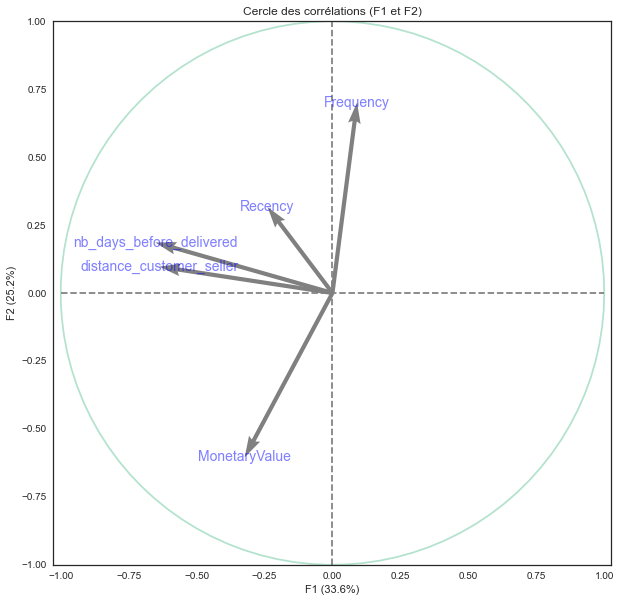

In [73]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

## 3.2) Modélisation : K-Means

In [74]:
wcss = []
tab_silhouette = []
for i in range (2,11):
    Kmeans = KMeans(n_clusters=i,random_state=42)
    cluster_labels = Kmeans.fit_predict(customers_transform)
    wcss.append(Kmeans.inertia_)
    tab_silhouette.append(silhouette_score(customers_transform, cluster_labels))

In [187]:
tab_silhouette

[0.40712804287144927,
 0.4450801039899593,
 0.34654450184520363,
 0.34041729215258637,
 0.34412873621659795,
 0.3357261599584611,
 0.32175282788334386,
 0.3238744060125561,
 0.3231960662776363]

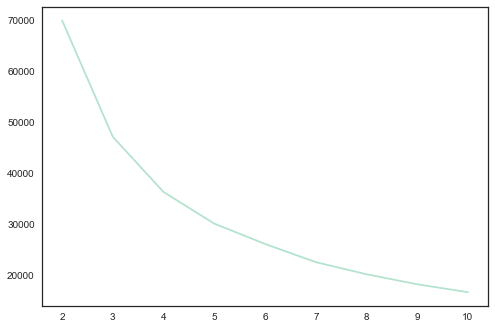

In [188]:
plt.plot(range(2,11),wcss)

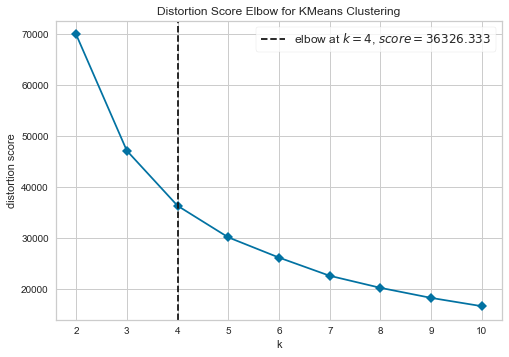

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [86]:
model = KMeans()
visualizer = KElbowVisualizer(model, k =(2,11), timings=False)
visualizer.fit(customers_transform)
visualizer.show()

In [190]:
sns.set_palette("Pastel2")
sns.set_style("ticks")

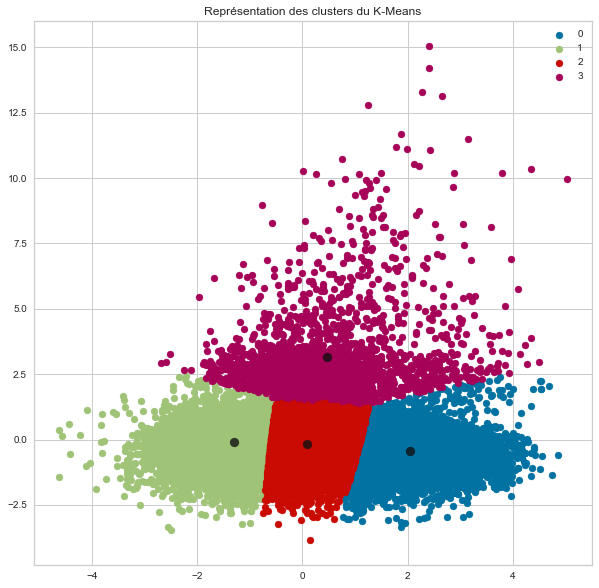

In [87]:
model = KMeans(n_clusters=4, random_state=42)

label = model.fit_predict(customers_transform)
centroids = model.cluster_centers_
u_labels = np.unique(label)

plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(customers_transform[label == i , 0] ,customers_transform[label == i , 1] , label=i)
plt.scatter(centroids[:,0], centroids[:,1] , s = 80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [20]:
model.labels_

array([3, 1, 3, ..., 1, 2, 1])

In [21]:
data["Cluster"] = model.labels_
data_clusters_analysis = data.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'nb_days_before_delivered' : "mean",
    "distance_customer_seller" : "mean",
    "product_category_name" : lambda x : x.value_counts().index[0],
    "customer_city" : lambda x : x.value_counts().index[0],
    "review_score" : "mean"}).round(2)
data_clusters_analysis

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,distance_customer_seller,product_category_name,customer_city,review_score
Cluster,,,,,,,,
0,223.79,1.02,106.39,3.85,80.56,health_beauty,sao paulo,4.39
1,333.64,1.01,227.20,19.34,1083.73,health_beauty,rio de janeiro,3.86
2,276.55,1.01,131.99,8.78,459.35,bed_bath_table,sao paulo,4.30
3,328.18,2.58,47.68,12.56,633.98,bed_bath_table,sao paulo,4.12


L'analyse des moyennes associées à chaque cluster nous a permis de pouvoir mieux décrire nos segments de clientèles. On va se retrouver avec 4 segments:

Le client moyen : Il a acheté plus de deux fois et dépense une somme moyenne. Les avis laissés par ce client sont plutôt positifs. Il commande auprès de vendeurs qui se trouvent à une distance moyenne de lui. Les délais de livraison sont moyens.

Le client exigent : Il a commandé plus de deux fois et dépense des sommes importantes. Les avis laissés par ce type de client sont parmi les moins bons. Il commande des produits qui se trouvent à une grande distance de chez lui

Le client fidèle : Il a commandé plus de deux fois. C'est aussi celui qui a la moyenne d'achat la plus faible. Il habite à une distance moyenne de son vendeur et le délai de livraison est moyen (environ 8 jours).

Le client satisfait : Il a commandé plus de deux 3 fois. Il se distingue des autres par ses avis plus élevés que la moyenne.

In [22]:
df_normalized = pd.DataFrame(customers_normalized, columns=["Recency",
                                                            "Frequency",'MonetaryValue', 
                                                            "nb_days_before_delivered", "distance_customer_seller"])
df_normalized['ID'] = data.index
df_normalized["Cluster"] = model.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue",
                                  "nb_days_before_delivered", "distance_customer_seller"],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,000e309254ab1fc5ba99dd469d36bdb4,3,Recency,-1.220704
1,0028a7d8db7b0247652509358ad8d755,1,Recency,0.376975
2,00324c9f4d710e7bac5c5ba679714430,3,Recency,1.101083
3,00986cafefb6e670cceca01694bda599,3,Recency,0.274173
4,00a9fd000ff87bb48b989df819c418f5,3,Recency,-0.232983


In [23]:
df_nor_melt['Cluster'].value_counts()

2    79960
1    63250
0    33960
3    11245
Name: Cluster, dtype: int64

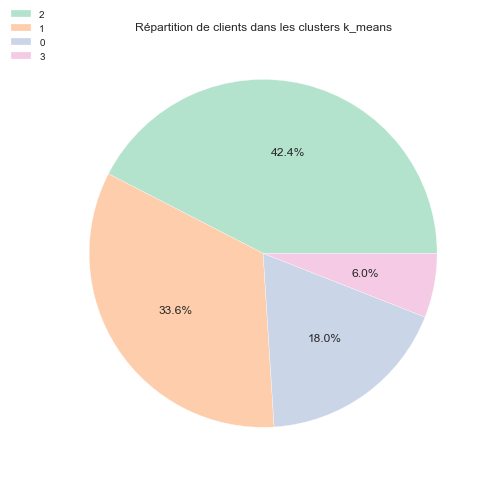

In [296]:
fig = plt.figure(figsize=(8, 8))

plt.title('Répartition de clients dans les clusters k_means')
plt.pie(effectif_clusters_k_means_4['Cluster'], autopct='%1.1f%%')
plt.legend(effectif_clusters_k_means_4.index,
           loc='center left', bbox_to_anchor=(-0.1, 1.))

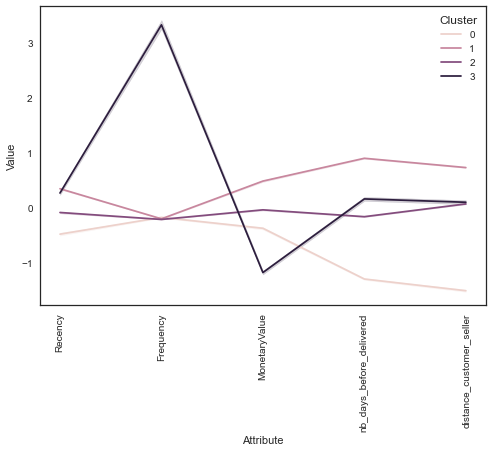

In [297]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.xticks(rotation=90)
plt.show()

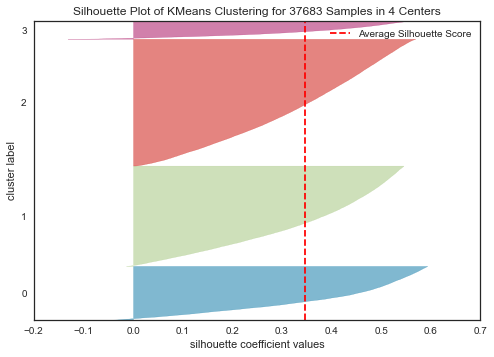

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 37683 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [298]:
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(customers_transform)
visualizer.show()

In [69]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", \
      silhouette_score(customers_transform,\
                       label))
print("Score de Davies-Bouldin:", \
      davies_bouldin_score(customers_transform,\
                           label))

Silhouette Score: 0.3465445018452038
Score de Davies-Bouldin: 0.9151423959413022


In [75]:
intercluster_distance(KMeans(5, random_state=42), customers_transform)

NameError: name 'intercluster_distance' is not defined

L'ajout de variable a permis d'obtenir une segmentation en 4 segments. On remarque que nos segments sont plutôt équilibrés mais qu'un segment contient moins de clients. Il s'agit des clients qui ont plusieurs commandes à leurs actifs. Il est aussi possible de distinguer des clients qui commandent à des vendeurs proches de leur lieu d'habitation ou encore des clients qui dépensent plus que les autres. 



In [201]:
data.to_csv("C:/Users/lenovo/Olist/data_kmeans_clusters.csv")

# Conclusion

L'utilisation d'algorithme de Machine Learning permet d'obtenir des segments actionnables en prenant en compte plus de variable que les segmentations classiques, type RFM. On va aussi pouvoir obtenir moins de segments de clientèle (4 segments avec des algorithmes de clustering vs 32 segments avec la segmentation RFM). Il sera donc probablement plus aisé de faire des offres une fois les 5 segments définis que lorsqu'on a défini 32 segments. 